In [2]:
train_file_path = "../data/pathology/all/train_data.json"
val_file_path = "../data/pathology/all/val_data.json"
test_file_path = "../data/pathology/all/test_data.json"

import re
import json 
from transformers import AutoTokenizer
import torch

def word_count(str):
    return len([word for word in str.split() 
                if word not in [":", ",", "-", ";", ".", "(", ")"]])

def read_file(str):
    with open(str) as f:
        file = json.load(f)
    return file

def medical_report_statistics(file):
    sentence_pattern = r'(?<=[.?!])(?=\s(?![0-9]))|(?<=\n)'

    stats = {}
    stats['H&E'] = {}
    stats['H&E']['n_sentences'] = []
    stats['H&E']['n_words'] = []
    stats['H&E']['n_tokens'] = []
    stats['H&E']['image_id'] = []
    stats['H&E']['report'] = []

    stats['ALL'] = {}
    stats['ALL']['n_sentences'] = []
    stats['ALL']['n_words'] = []
    stats['ALL']['n_tokens'] = []
    stats['ALL']['image_id'] = []
    stats['ALL']['report'] = []

    for medical_report in file:
        # Caption with only H&E information
        n_sentences = len(re.split(sentence_pattern, medical_report['caption']))
        n_words = word_count(medical_report['caption'])  
        n_tokens = len(biogpt_tokenizer(medical_report['caption'])['input_ids'])
        stats['H&E']['n_sentences'].append(n_sentences)
        stats['H&E']['n_words'].append(n_words)
        stats['H&E']['n_tokens'].append(n_tokens)
        stats['H&E']['image_id'].append(medical_report['image_id'])
        stats['H&E']['report'].append(medical_report['caption'])

        # Complete medical report
        n_sentences = len(re.split(sentence_pattern, medical_report['caption_all']))
        n_words = word_count(medical_report['caption_all'])
        n_tokens = len(biogpt_tokenizer(medical_report['caption_all'])['input_ids'])
        stats['ALL']['n_sentences'].append(n_sentences)
        stats['ALL']['n_words'].append(n_words)
        stats['ALL']['n_tokens'].append(n_tokens)
        stats['ALL']['image_id'].append(medical_report['image_id'])
        stats['ALL']['report'].append(medical_report['caption_all'])
    
    return stats

biogpt_tokenizer = AutoTokenizer.from_pretrained(
    "microsoft/biogpt", torch_dtype=torch.float16
)

train = read_file(train_file_path)
val = read_file(val_file_path)
test = read_file(test_file_path)

train_stats = medical_report_statistics(train)
val_stats = medical_report_statistics(val)
test_stats = medical_report_statistics(test)

In [6]:
import pandas as pd

train_df = pd.DataFrame(train_stats)
train_df = train_df.applymap(lambda x: sum(map(int, x)) if isinstance(x, list) and all(isinstance(i, int) for i in x) else x)
train_df

,H&E,ALL
n_sentences,103435,148685
n_words,1140302,1707689
n_tokens,1433326,2144608
image_id,237630528,237630528
report,"[Skin excision specimen composed of epidermis,...","[Skin excision specimen composed of epidermis,..."


In [7]:
val_df = pd.DataFrame(val_stats)

val_df = val_df.applymap(lambda x: sum(map(int, x)) if isinstance(x, list) and all(isinstance(i, int) for i in x) else x)

In [8]:
test_df = pd.DataFrame(test_stats)

test_df = test_df.applymap(lambda x: sum(map(int, x)) if isinstance(x, list) and all(isinstance(i, int) for i in x) else x)

In [9]:
total_df = (train_df + val_df + test_df)
# total_df['Total'] = total_df['H&E'] + total_df['ALL']

total_df.T

,n_sentences,n_words,n_tokens,image_id,report
H&E,129121,1425573,1791386,296385665,"[Skin excision specimen composed of epidermis,..."
ALL,185570,2132008,2677405,296385665,"[Skin excision specimen composed of epidermis,..."


In [10]:
print(train_df)
print(val_df)
print(test_df)

                                                           H&E  \
n_sentences                                             103435   
n_words                                                1140302   
n_tokens                                               1433326   
image_id                                             237630528   
report       [Skin excision specimen composed of epidermis,...   

                                                           ALL  
n_sentences                                             148685  
n_words                                                1707689  
n_tokens                                               2144608  
image_id                                             237630528  
report       [Skin excision specimen composed of epidermis,...  
                                                           H&E  \
n_sentences                                              12945   
n_words                                                 142876   
n_tokens       

In [11]:
HandE_df = pd.concat([pd.DataFrame(train_stats['H&E']), pd.DataFrame(val_stats['H&E']), pd.DataFrame(test_stats['H&E'])]).set_index('image_id')
ALL_df = pd.concat([pd.DataFrame(train_stats['ALL']), pd.DataFrame(val_stats['ALL']), pd.DataFrame(test_stats['ALL'])]).set_index('image_id')

In [14]:
with open('../data/patient_info/patient_characteristics.xlsx', 'rb') as f:
    patient_info = pd.read_excel(f)

with open('../data/patient_info/report_id_specimen_map.json', 'rb') as f:
    report_id_specimen_map = json.load(f)

In [15]:
patient_info['specimen'] = patient_info['specimen'].apply(
    lambda x: x[:9] + "_" + x[9:]
)

In [16]:
specimen_report_id_map = {v: k for k, v in report_id_specimen_map.items()}
mapping = patient_info[['specimen', 'label']].set_index('specimen').to_dict()['label']

HandE_df['specimen'] = HandE_df.index.map(specimen_report_id_map)
HandE_df['label'] = HandE_df['specimen'].map(mapping)

ALL_df['specimen'] = ALL_df.index.map(specimen_report_id_map)
ALL_df['label'] = ALL_df['specimen'].map(mapping)

In [17]:
HandE_df['n_words_HandE'] = HandE_df['n_words']
ALL_df['n_words_ALL'] = ALL_df['n_words']

HandE_merge = HandE_df[['n_words_HandE', 'label']]
ALL_merge = ALL_df[['n_words_ALL', 'label']]

In [18]:
merged_df = pd.merge(HandE_merge, ALL_merge, on=HandE_merge.index)

In [19]:
merged_df['percentage'] = (merged_df['n_words_HandE'] / merged_df['n_words_ALL']) 
merged_df.groupby('label_x')['percentage'].mean()

label_x
False    0.747195
True     0.569945
Name: percentage, dtype: float64

In [20]:
merged_df.groupby('label_x')['n_words_HandE'].sum() / merged_df.groupby('label_x')['n_words_ALL'].sum()

label_x
False    0.741311
True     0.518291
dtype: float64

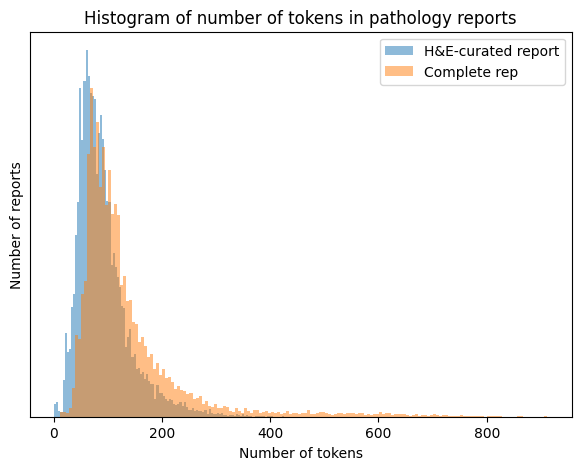

In [21]:
import matplotlib.pyplot as plt

fig, ax = plt.subplots(1, 1, figsize=(7, 5))
# create a histogram plot 
ax.hist(HandE_df['n_tokens'], bins='auto', density=True, alpha=0.5, label='H&E-curated report')
ax.hist(ALL_df['n_tokens'], bins='auto', density=True, alpha=0.5, label='Complete rep')
plt.xlabel('Number of tokens')
# off the yticks
plt.yticks([])
plt.ylabel('Number of reports')
plt.legend()
plt.title('Histogram of number of tokens in pathology reports');

/tmp/ipykernel_51079/378384570.py:10: MatplotlibDeprecationWarning: The seaborn styles shipped by Matplotlib are deprecated since 3.6, as they no longer correspond to the styles shipped by seaborn. However, they will remain available as 'seaborn-v0_8-<style>'. Alternatively, directly use the seaborn API instead.
  plt.style.use('seaborn-whitegrid')


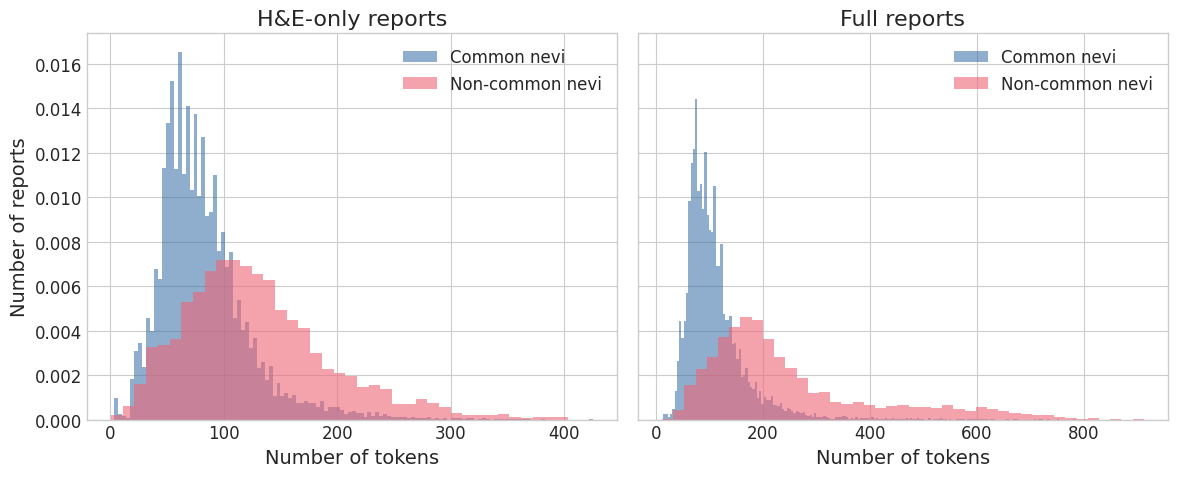

In [22]:
import matplotlib.pyplot as plt

# Subset the data
he_true  = HandE_df[HandE_df['label'] == True]['n_tokens']
he_false = HandE_df[HandE_df['label'] == False]['n_tokens']
all_true  = ALL_df[ALL_df['label'] == True]['n_tokens']
all_false = ALL_df[ALL_df['label'] == False]['n_tokens']

# 1) Use a clean style
plt.style.use('seaborn-whitegrid')

# 2) Increase font sizes
plt.rcParams.update({
    'font.size': 14,
    'axes.titlesize': 16,
    'axes.labelsize': 14,
    'legend.fontsize': 12,
    'xtick.labelsize': 12,
    'ytick.labelsize': 12
})

# 3) Create subplots
fig, axes = plt.subplots(1, 2, figsize=(12, 5), sharey=True)

# Define custom colors for "Common Nevi" (False) vs. "Non-Common Nevi" (True)
colors = ["#4477AA", "#EE6677"]  # Two colorblind-friendly color

# Left plot: H&E-curated reports
axes[0].hist(he_false, bins='auto', color=colors[0], alpha=0.6, density=True, label='Common nevi')
axes[0].hist(he_true,  bins='auto', color=colors[1], alpha=0.6, density=True, label='Non-common nevi')
axes[0].set_title('H&E-only reports')
axes[0].set_xlabel('Number of tokens')
axes[0].set_ylabel('Number of reports')
axes[0].legend(loc='upper right')

# Right plot: Complete reports
axes[1].hist(all_false, bins='auto', color=colors[0], density=True, alpha=0.6, label='Common nevi')
axes[1].hist(all_true,  bins='auto', color=colors[1], density=True, alpha=0.6, label='Non-common nevi')
axes[1].set_title('Full reports')
axes[1].set_xlabel('Number of tokens')
axes[1].legend(loc='upper right')

# 4) Overall title & layout
# fig.suptitle('Distribution of Tokens by Melanocytic Lesion Type', fontsize=18, y=0.98, fontweight='bold')
plt.tight_layout()
plt.show()


/tmp/ipykernel_51079/2091882818.py:15: MatplotlibDeprecationWarning: The seaborn styles shipped by Matplotlib are deprecated since 3.6, as they no longer correspond to the styles shipped by seaborn. However, they will remain available as 'seaborn-v0_8-<style>'. Alternatively, directly use the seaborn API instead.
  plt.style.use('seaborn-whitegrid')


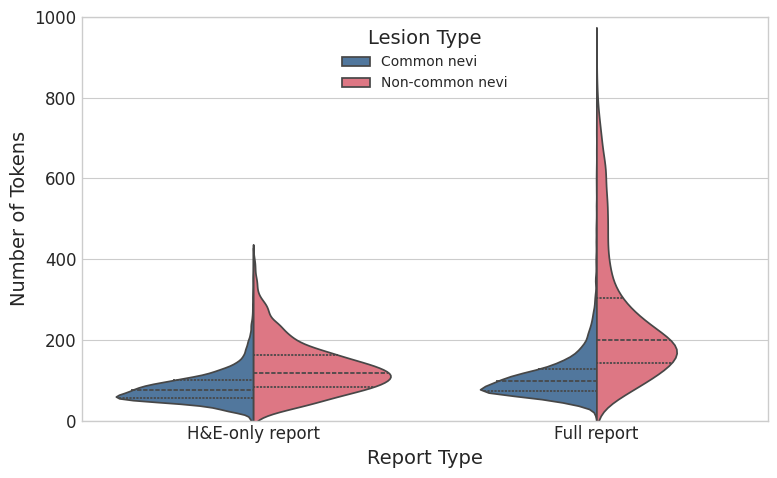

In [37]:
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd

# Combine data into a structured format for Seaborn
data = pd.DataFrame({
    'n_tokens': list(he_false) + list(he_true) + list(all_false) + list(all_true),
    'Report Type': (['H&E-only report'] * (len(he_false) + len(he_true))) + 
                   (['Full report'] * (len(all_false) + len(all_true))),
    'Label': (['Common nevi'] * len(he_false)) + (['Non-common nevi'] * len(he_true)) +
             (['Common nevi'] * len(all_false)) + (['Non-common nevi'] * len(all_true))
})

# 1) Use a clean style
plt.style.use('seaborn-whitegrid')

# 2) Increase font sizes
plt.rcParams.update({
    'font.size': 14,
    'axes.titlesize': 16,
    'axes.labelsize': 14,
    'legend.fontsize': 12,
    'xtick.labelsize': 12,
    'ytick.labelsize': 12
})

# 2) Create figure
fig, ax = plt.subplots(figsize=(8, 5))

# Define custom colorblind-friendly palette
colors = ["#4477AA", "#EE6677"]  # Common nevi (blue) / Non-common nevi (red)

# 3) Plot a single split violin plot
sns.violinplot(data=data, x='Report Type', y='n_tokens', hue='Label', 
               split=True, palette=colors, ax=ax, inner='quart')

# 4) Adjust aesthetics
# ax.set_title('Distribution of Tokens by Report Type', fontsize=16, fontweight='bold')
ax.set_ylabel('Number of Tokens')
ax.legend(title="Lesion Type", fontsize=10, loc='upper center')
ax.set_ylim(0, 1000)

# 5) Show plot
plt.tight_layout()
plt.show()

In [24]:
print(he_false.describe())
print()
print(he_true.describe())

count    16090.000000
mean        82.835364
std         40.770442
min          4.000000
25%         56.000000
50%         75.000000
75%        100.000000
max        425.000000
Name: n_tokens, dtype: float64

count    3546.000000
mean      129.318951
std        64.796538
min         1.000000
25%        84.000000
50%       119.000000
75%       162.750000
max       403.000000
Name: n_tokens, dtype: float64


In [25]:
print(all_false.describe())
print()
print(all_true.describe())

count    16090.000000
mean       111.078123
std         61.741533
min         14.000000
25%         74.000000
50%         97.000000
75%        128.000000
max        783.000000
Name: n_tokens, dtype: float64

count    3546.000000
mean      251.031585
std       160.059013
min        12.000000
25%       143.000000
50%       200.000000
75%       303.000000
max       912.000000
Name: n_tokens, dtype: float64


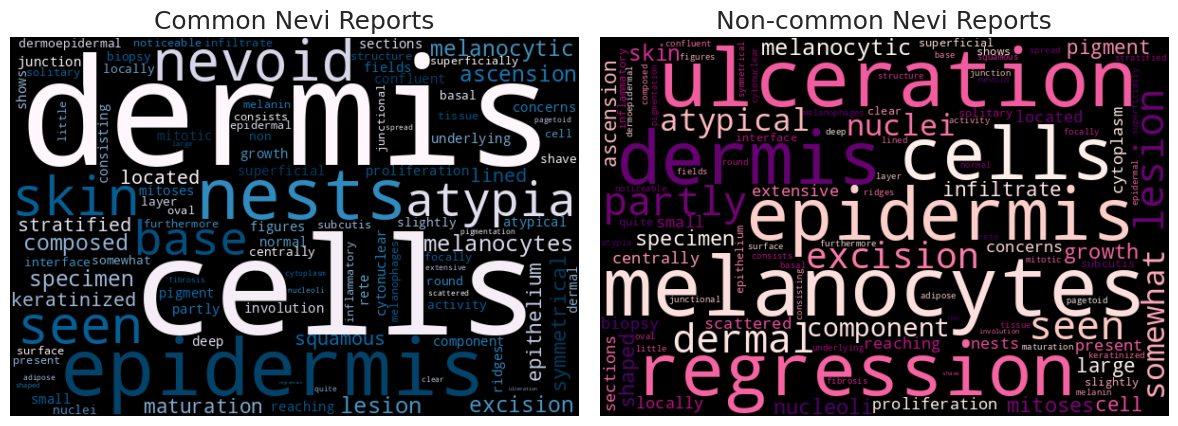

In [26]:
import pandas as pd
import matplotlib.pyplot as plt
from wordcloud import WordCloud
from sklearn.feature_extraction.text import TfidfVectorizer

# Assuming your dataset has 'report_text' (text data) and 'label' (False = Common nevi, True = Non-common nevi)
common_nevi_texts = HandE_df[HandE_df['label'] == False]['report'].tolist()
non_common_nevi_texts = HandE_df[HandE_df['label'] == True]['report'].tolist()

# Combine both into a single list of documents
all_texts = common_nevi_texts + non_common_nevi_texts
labels = (['Common nevi'] * len(common_nevi_texts)) + (['Non-common nevi'] * len(non_common_nevi_texts))

# TF-IDF Vectorization (keeping individual reports separate)
vectorizer = TfidfVectorizer(stop_words='english', max_features=100)
tfidf_matrix = vectorizer.fit_transform(all_texts)
tfidf_feature_names = vectorizer.get_feature_names_out()

# Convert TF-IDF matrix to DataFrame
tfidf_df = pd.DataFrame(tfidf_matrix.toarray(), columns=tfidf_feature_names)
tfidf_df['Label'] = labels

# Compute **average TF-IDF score per word** for each category
common_tfidf_scores = tfidf_df[tfidf_df['Label'] == 'Common nevi'].drop(columns=['Label']).mean().to_dict()
non_common_tfidf_scores = tfidf_df[tfidf_df['Label'] == 'Non-common nevi'].drop(columns=['Label']).mean().to_dict()

# Generate Word Clouds
fig, axes = plt.subplots(1, 2, figsize=(12, 6))

# Common nevi word cloud
wordcloud_common = WordCloud(width=600, height=400, background_color='black', colormap='PuBu').generate_from_frequencies(common_tfidf_scores)
axes[0].imshow(wordcloud_common, interpolation="bilinear")
axes[0].axis("off")
axes[0].set_title("Common Nevi Reports", fontsize=18)

# Non-common nevi word cloud
wordcloud_non_common = WordCloud(width=600, height=400, background_color='black', colormap='RdPu').generate_from_frequencies(non_common_tfidf_scores)
axes[1].imshow(wordcloud_non_common, interpolation="bilinear")
axes[1].axis("off")
axes[1].set_title("Non-common Nevi Reports", fontsize=18)

plt.tight_layout()
plt.show()


[nltk_data] Downloading package stopwords to
[nltk_data]     /home/tvandeluijtgaarden/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


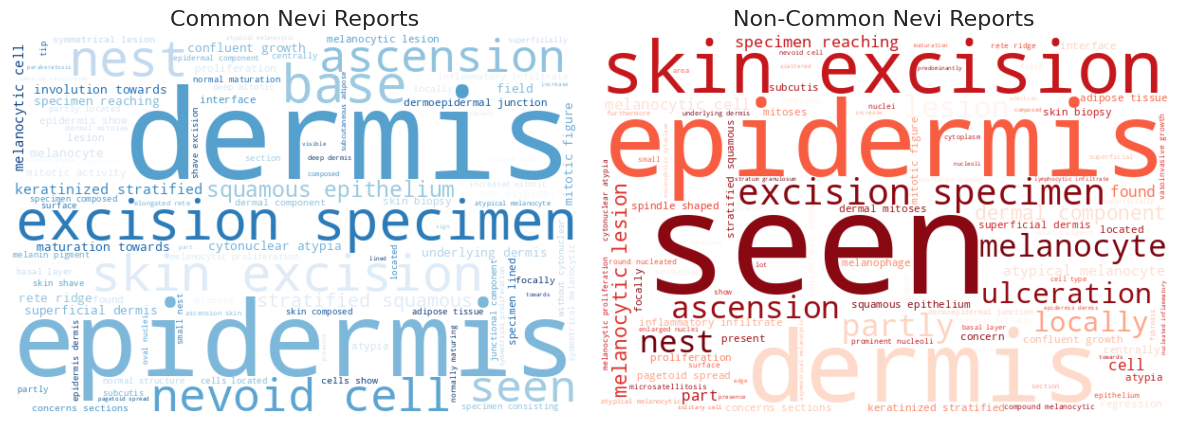

In [27]:
import pandas as pd
import matplotlib.pyplot as plt
from wordcloud import WordCloud
from collections import Counter
import re
import nltk
from nltk.corpus import stopwords

# Download stopwords if not already available
nltk.download('stopwords')
stop_words = set(stopwords.words('english'))

# Function to clean text
def clean_text(text):
    text = text.lower()  # Convert to lowercase
    text = re.sub(r'\W+', ' ', text)  # Remove special characters
    # text = ' '.join([word for word in text.split() if word not in stop_words])  # Remove stopwords
    return text

# Extract text for each category
common_nevi_texts = " ".join(HandE_df[HandE_df['label'] == False]['report'].apply(clean_text))
non_common_nevi_texts = " ".join(HandE_df[HandE_df['label'] == True]['report'].apply(clean_text))

# Generate Word Clouds
fig, axes = plt.subplots(1, 2, figsize=(12, 6))

# Common Nevi Word Cloud
wordcloud_common = WordCloud(width=600, height=400, background_color='white', colormap='Blues', max_words=100).generate(common_nevi_texts)
axes[0].imshow(wordcloud_common, interpolation="bilinear")
axes[0].axis("off")
axes[0].set_title("Common Nevi Reports", fontsize=16)

# Non-Common Nevi Word Cloud
wordcloud_non_common = WordCloud(width=600, height=400, background_color='white', colormap='Reds', max_words=100).generate(non_common_nevi_texts)
axes[1].imshow(wordcloud_non_common, interpolation="bilinear")
axes[1].axis("off")
axes[1].set_title("Non-Common Nevi Reports", fontsize=16)

plt.tight_layout()
plt.show()


In [28]:
with open("../data/patient_info/patient_characteristics.xlsx", 'rb') as f:
    diagnosis_map = pd.read_excel(f, sheet_name='Table')

diagnosis_mapsss = diagnosis_map.iloc[:, :7].fillna(0)
diagnosis_mapsss[['Unnamed: 3', 'Unnamed: 4', 'Unnamed: 5', 'Unnamed: 6']] = diagnosis_mapsss[['Unnamed: 3', 'Unnamed: 4', 'Unnamed: 5', 'Unnamed: 6']].astype(int)

In [29]:
all_types = diagnosis_mapsss[['Unnamed: 3', 'Unnamed: 4', 'Unnamed: 5', 'Unnamed: 6']].melt()['value'].unique().astype(int)[1:]


In [30]:
with open("../data/patient_info/patient_characteristics.xlsx", 'rb') as f:
    mapping = pd.read_excel(f, sheet_name='Mapping')
diagnosis_map2 = mapping.iloc[:,:4].set_index('Diagnose code')[['Engels']]

In [31]:
diagnosis_map2

,Engels
Diagnose code,
1,Compound nevus
2,Dermal nevus
3,Junctional nevus
21,Multiple common nevi
4,Superficial spreading melanoma
...,...
61,Melanoma metastasis (+ pre-existing nevus)
62,Acral melanoma (+ pre-existing nevus)
63,Proliferative node


In [32]:
patient_info_curated = patient_info[patient_info['specimen'].isin(HandE_df['specimen'].to_list())]
patient_info_curated['Diagnosis'] = patient_info_curated['diagnosis code'].map(diagnosis_map2.to_dict()['Engels'])

/tmp/ipykernel_51079/657871804.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  patient_info_curated['Diagnosis'] = patient_info_curated['diagnosis code'].map(diagnosis_map2.to_dict()['Engels'])


In [33]:
diagnosis_mapsss['Unnamed: 3'] = diagnosis_mapsss['Unnamed: 3'].map(patient_info_curated['diagnosis code'].value_counts().to_dict())
diagnosis_mapsss['Unnamed: 4'] = diagnosis_mapsss['Unnamed: 4'].map(patient_info_curated['diagnosis code'].value_counts().to_dict())
diagnosis_mapsss['Unnamed: 5'] = diagnosis_mapsss['Unnamed: 5'].map(patient_info_curated['diagnosis code'].value_counts().to_dict())
diagnosis_mapsss['Unnamed: 6'] = diagnosis_mapsss['Unnamed: 6'].map(patient_info_curated['diagnosis code'].value_counts().to_dict())

In [34]:
diagnosis_mapsss[['Unnamed: 3', 'Unnamed: 4', 'Unnamed: 5', 'Unnamed: 6']]

,Unnamed: 3,Unnamed: 4,Unnamed: 5,Unnamed: 6
0,NaN,NaN,NaN,NaN
1,NaN,NaN,NaN,NaN
2,NaN,NaN,NaN,NaN
3,7542.0,NaN,NaN,NaN
4,7186.0,NaN,NaN,NaN
5,1335.0,NaN,NaN,NaN
6,27.0,NaN,NaN,NaN
7,NaN,NaN,NaN,NaN
8,NaN,NaN,NaN,NaN
9,331.0,11.0,NaN,NaN


In [35]:
df2 = mapping.iloc[:46,11:15]
df2

,Unnamed: 11,normal,pre-existing nevus,Additional common nevus as accidental finding
0,NaN,X,NaN,NaN
1,NaN,X,NaN,NaN
2,Dermal nevus,2,NaN,NaN
3,Compound nevus,1,NaN,NaN
4,Junctional nevus,3,NaN,NaN
5,Multiple common nevi,21,NaN,NaN
6,NaN,NaN,NaN,NaN
7,NaN,X,NaN,NaN
8,NaN,X,NaN,NaN
9,Blue nevi,7,38.00,NaN
